Set-up

In [12]:
#!pip install shap
#!pip install scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import shap
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, KFold, StratifiedKFold, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, make_scorer, confusion_matrix, roc_curve, auc, mean_squared_error, r2_score, roc_auc_score, f1_score, precision_score, recall_score, precision_recall_curve
from sklearn.naive_bayes import GaussianNB

In [2]:
df = pd.read_csv('base_completa.csv')

In [3]:
# Calculate the percentage of missing values for each column
missing_percentages = df.isnull().mean() * 100

# Display the missing value percentages
print(missing_percentages)

idum                 0.000000
sex                  0.000000
age                  0.000000
age_diagnosis        1.030928
months_follow_up     1.030928
                      ...    
plt_basal            3.092784
lym_basal            3.092784
neu_basal            3.092784
lym_basal.1         24.742268
ney_basal           24.742268
Length: 75, dtype: float64


Imputation

In [4]:
categorical_vars = [
    'sex', 'hem_activity', 'thromocytopenia', 'grade_thrombocytopenia', 'ahai',
    'treatment_thrombocytopenia', 'splenectomy', 'obs_compl', 'thrombotic_compl',
    'arterial_venous', 'tvp', 'pe', 'other_tvp', 'stroke', 'ami', 'death', 'extra_criteria',
    'livedo', 'ulcers', 'nephropathy', 'valvulopathy', 'neurological', 'hypertension', 'diabetes',
    'dislipidemia', 'smoke', 'statins', 'aspirin', 'drug', 'anticoagulant', 'type_anticoagulant',
    'dual_treatment', 'hqc', 'immunosupressor', 'prednisone', 'azathioprine', 'micophenolate',
    'gassp', 'lupic_anticoag', 'acl_igg', 'acl_igm', 'b2_igg', 'bg_igm', 'triple_ab',
    'acl_IgG_actD', 'acl_igM_actD', 'antiB2_IgG_actD', 'antiB2_IgM_actD', 'aPT_igG_dic', 'apt_igM_dico']

# Convert categorical variables to the categorical data type
for var in categorical_vars:
    df[var] = df[var].astype('category')

In [5]:
# Split the data into train and test sets to evaluate different k values
train, test = train_test_split(df, test_size=0.2, random_state=40)

# Reset index to avoid KeyError issues
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

# Function to evaluate KNN imputer with different k values
def evaluate_knn_imputer(train, test, k):
    imputer = KNNImputer(n_neighbors=k)
    train_imputed = imputer.fit_transform(train)
    test_imputed = imputer.transform(test)

    train_imputed_df = pd.DataFrame(train_imputed, columns=df.columns)
    test_imputed_df = pd.DataFrame(test_imputed, columns=df.columns)

    # Evaluate performance by comparing test set imputed values to the true values
    mse_scores = []

    for col in df.columns:
        true_values = test[col].dropna()  # True values without missing
        pred_values = test_imputed_df.loc[true_values.index, col]  # Predicted imputed values

        # Calculate Mean Squared Error (MSE) for each column
        mse = mean_squared_error(true_values, pred_values)
        mse_scores.append(mse)

    return np.mean(mse_scores)

# Hyperparameter search for the best k value
best_k = 2
best_mse = float('inf')

for k in range(2, 8):
    mse = evaluate_knn_imputer(train, test, k)
    print(f'k={k}, MSE={mse}')
    if mse < best_mse:
        best_mse = mse
        best_k = k

# Impute all variables with the best k
imputer = KNNImputer(n_neighbors=best_k)
df_imputed = imputer.fit_transform(df)
df_imputed = pd.DataFrame(df_imputed, columns=df.columns)


k=2, MSE=0.0
k=3, MSE=0.0
k=4, MSE=0.0
k=5, MSE=0.0
k=6, MSE=0.0
k=7, MSE=0.0


In [6]:
# Calculate the percentage of missing values for each column
missing_percentages = df_imputed.isnull().mean() * 100

# Display the missing value percentages
print(missing_percentages)

idum                0.0
sex                 0.0
age                 0.0
age_diagnosis       0.0
months_follow_up    0.0
                   ... 
plt_basal           0.0
lym_basal           0.0
neu_basal           0.0
lym_basal.1         0.0
ney_basal           0.0
Length: 75, dtype: float64


Logistic Regression: Accuracy = 0.6195, Precision = 0.6003, Recall = 0.6195, F1 Score = 0.5926
SVM: Accuracy = 0.6600, Precision = 0.4818, Recall = 0.6600, F1 Score = 0.5525
Random Forest: Accuracy = 0.7326, Precision = 0.7391, Recall = 0.7326, F1 Score = 0.7078
AdaBoost: Accuracy = 0.7847, Precision = 0.7831, Recall = 0.7847, F1 Score = 0.7700
Gradient Boosting: Accuracy = 0.7637, Precision = 0.7757, Recall = 0.7637, F1 Score = 0.7576
XGBoost: Accuracy = 0.7432, Precision = 0.7507, Recall = 0.7432, F1 Score = 0.7388


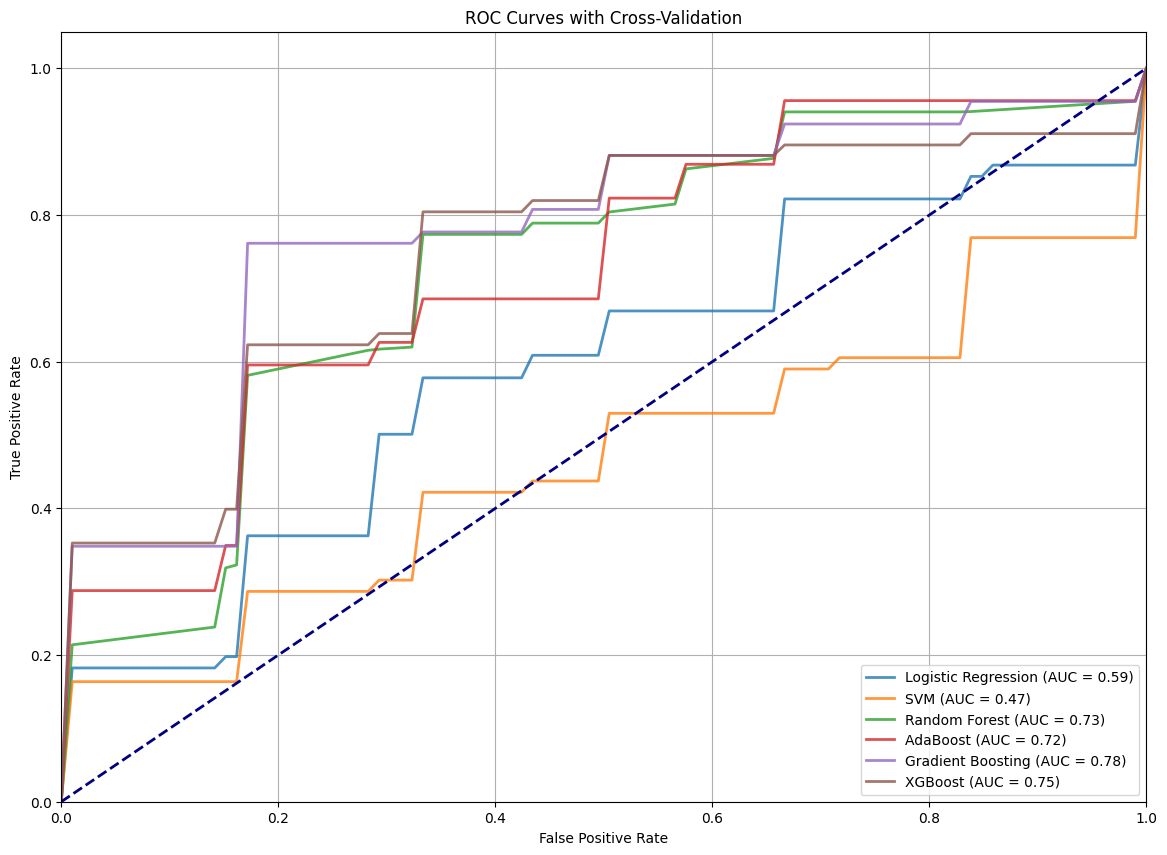

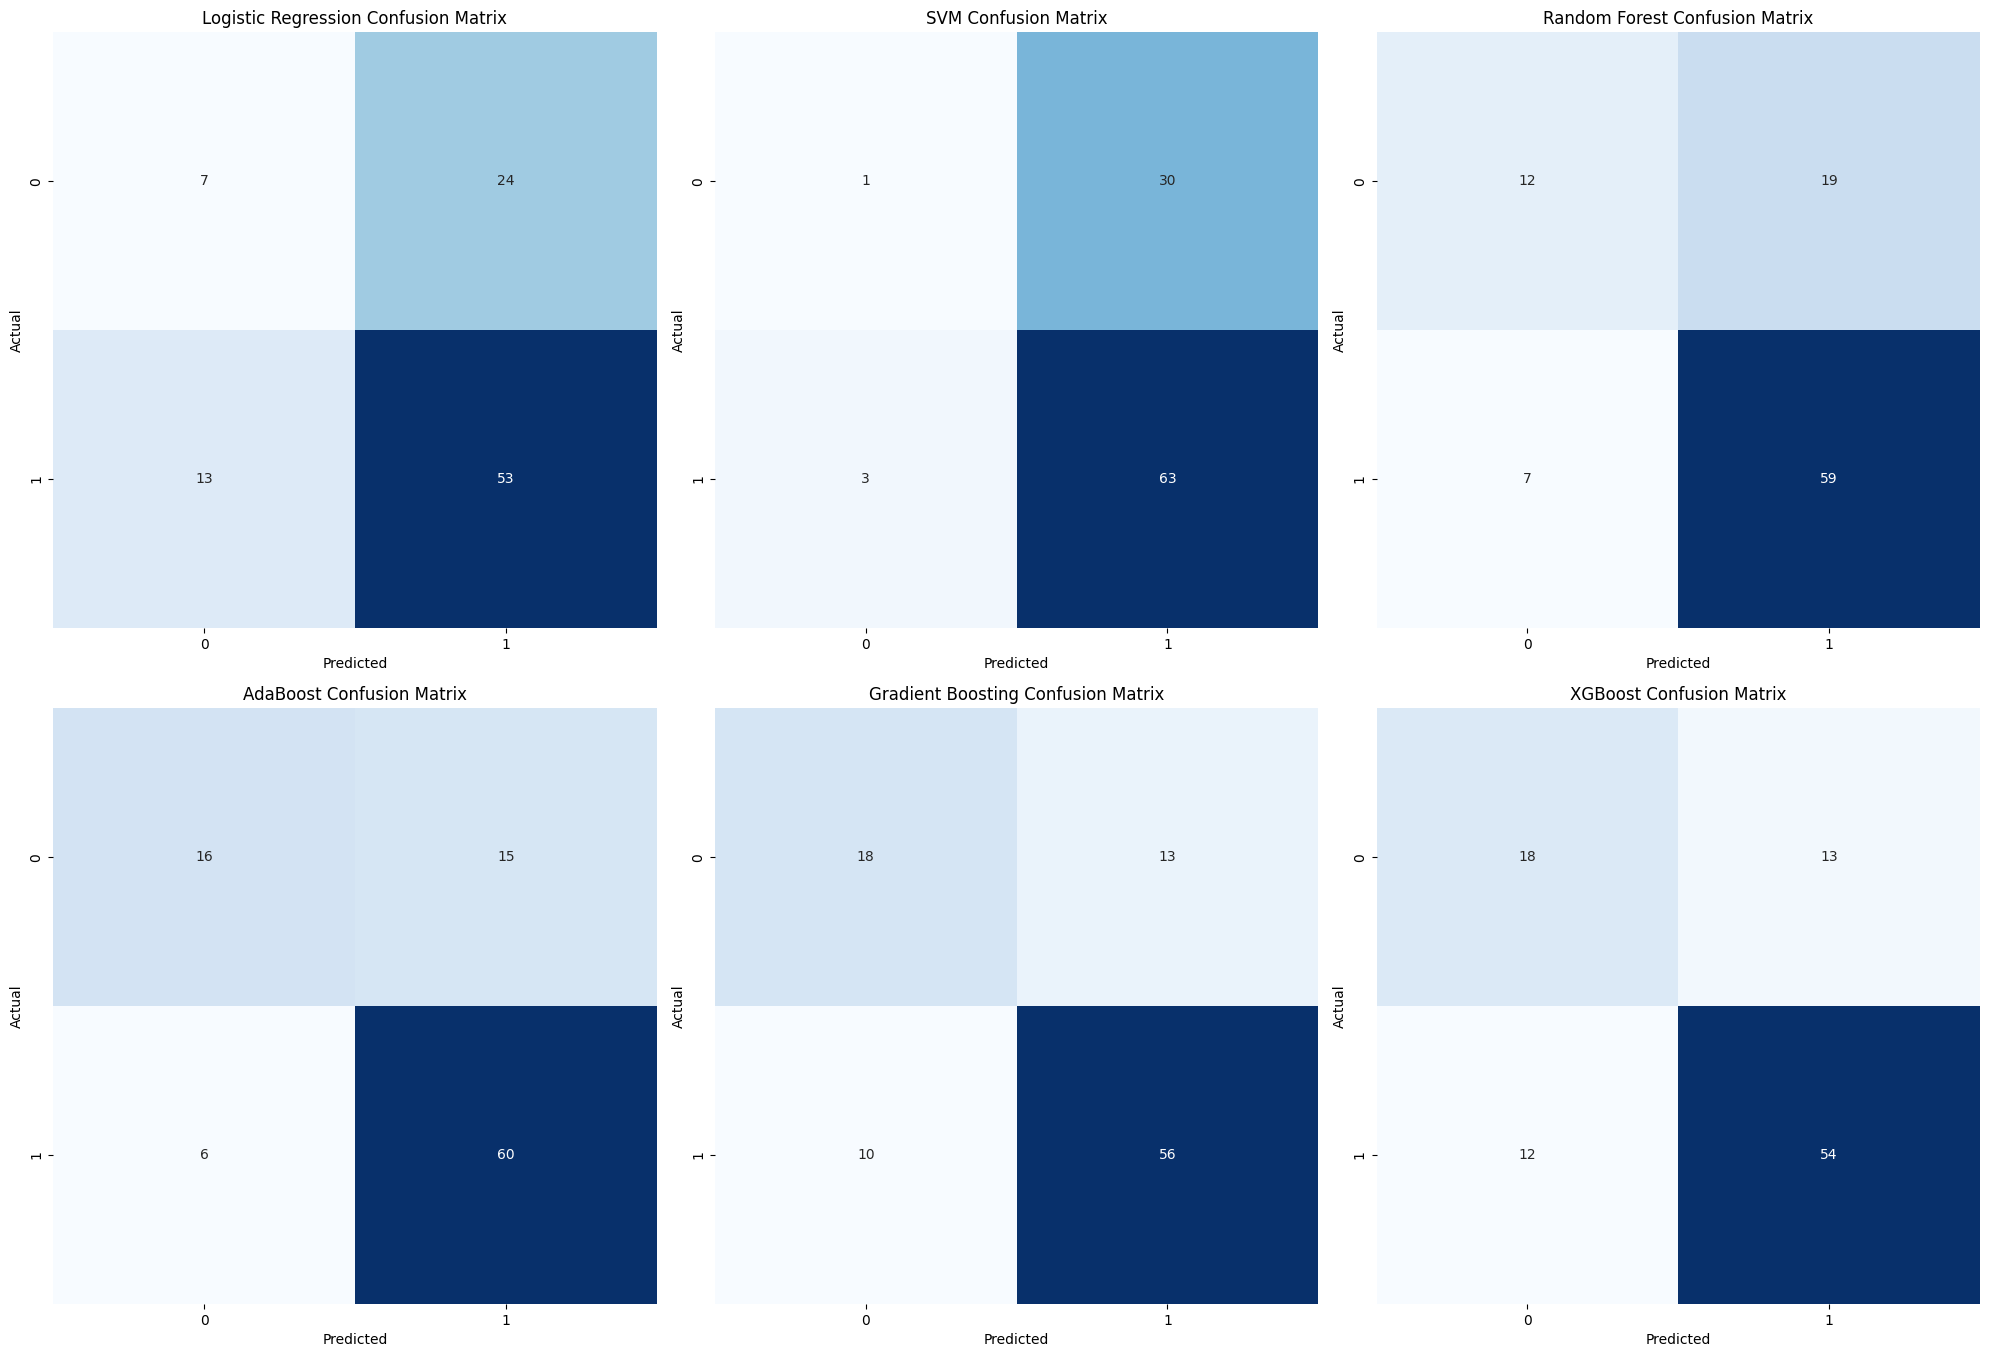

                     True Positives (TP)  True Negatives (TN)  \
Logistic Regression                   53                    7   
SVM                                   63                    1   
Random Forest                         59                   12   
AdaBoost                              60                   16   
Gradient Boosting                     56                   18   
XGBoost                               54                   18   

                     False Positives (FP)  False Negatives (FN)  
Logistic Regression                    24                    13  
SVM                                    30                     3  
Random Forest                          19                     7  
AdaBoost                               15                     6  
Gradient Boosting                      13                    10  
XGBoost                                13                    12  


In [13]:

# Prepare the column transformer for one-hot encoding and scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_vars2),
        ('cat', OneHotEncoder(), categorical_vars2)
    ])

# Set a global random seed
random_seed = 42
np.random.seed(random_seed)

# Adjusting Logistic Regression and SVM to handle undefined precision with zero_division
# Updated precision scorer to handle undefined precision
precision_scorer = make_scorer(precision_score, average='weighted', zero_division=0)

# Define the models with updated AdaBoost and XGBoost
models = {
    "Logistic Regression": Pipeline(steps=[('preprocessor', preprocessor),
                                           ('classifier', LogisticRegression(max_iter=10000, random_state=random_seed))]),
    "SVM": Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SVC(probability=True, random_state=random_seed))]),
    "Random Forest": Pipeline(steps=[('preprocessor', preprocessor),
                                     ('classifier', RandomForestClassifier(random_state=random_seed))]),
    "AdaBoost": Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', AdaBoostClassifier(algorithm='SAMME', random_state=random_seed))]),  # Use SAMME instead of SAMME.R
    "Gradient Boosting": Pipeline(steps=[('preprocessor', preprocessor),
                                         ('classifier', GradientBoostingClassifier(random_state=random_seed))]),
    "XGBoost": Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', XGBClassifier(eval_metric='logloss', random_state=random_seed))]),  # Removed use_label_encoder
}

# Function to evaluate models with cross-validation and handle precision with zero_division
def evaluate_models(models, X, y):
    results = {}
    for name, model in models.items():
        accuracy = cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()
        precision = cross_val_score(model, X, y, cv=5, scoring=precision_scorer, error_score='raise').mean()
        recall = cross_val_score(model, X, y, cv=5, scoring='recall_weighted', error_score='raise').mean()
        f1 = cross_val_score(model, X, y, cv=5, scoring='f1_weighted', error_score='raise').mean()

        results[name] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        }

        print(f'{name}: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}')

    return results

# Split the data into features and target
X = df_imputed[numerical_vars2 + categorical_vars2]
y = df_imputed[outcome_var]

# Evaluate the models
results = evaluate_models(models, X, y)

# Plotting ROC Curves with Cross-Validation
def plot_roc_curves_cv(models, X, y):
    cv = StratifiedKFold(n_splits=5)
    plt.figure(figsize=(14, 10))

    for name, model in models.items():
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)

        for train, test in cv.split(X, y):
            model.fit(X.iloc[train], y.iloc[train])
            y_prob = model.predict_proba(X.iloc[test])[:, 1]
            fpr, tpr, _ = roc_curve(y.iloc[test], y_prob)
            tprs.append(np.interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        plt.plot(mean_fpr, mean_tpr, lw=2, alpha=0.8, label=f'{name} (AUC = {mean_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves with Cross-Validation')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

# Plot ROC curves with cross-validation
plot_roc_curves_cv(models, X, y)

# Plotting Confusion Matrices with Cross-Validation and extracting TP, TN, FP, FN
def plot_confusion_matrices_cv(models, X, y):
    plt.figure(figsize=(20, 20))
    i = 1
    model_performance = {}

    for name, model in models.items():
        y_pred = cross_val_predict(model, X, y, cv=5)
        cm = confusion_matrix(y, y_pred)
        tn, fp, fn, tp = cm.ravel()
        model_performance[name] = {
            'True Positives (TP)': tp,
            'True Negatives (TN)': tn,
            'False Positives (FP)': fp,
            'False Negatives (FN)': fn
        }
        plt.subplot(3, 3, i)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'{name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        i += 1

    plt.tight_layout()
    plt.show()

    return model_performance

# Plot confusion matrices with cross-validation and get performance metrics
model_performance = plot_confusion_matrices_cv(models, X, y)

# Display the performance metrics
performance_df = pd.DataFrame(model_performance).T
print(performance_df)

In [19]:
# Define the numerical and categorical variables
numerical_vars2 = ['age_diagnosis', 'VPM_ingreso', 'plt_basal', 'lym_basal', 'neu_basal',
                   'acl_igg_actual', 'antiB2_IgG_actual',
                   'acL_igM_actual', 'antiB2_igM_actual', 'aPT_FS_IgG', 'aPT_FS_igM']

categorical_vars2 = ['sex', "lupic_anticoag"]

# Outcome variable
outcome_var = 'hem_activity'

# Prepare the column transformer for one-hot encoding and scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_vars2),
        ('cat', OneHotEncoder(), categorical_vars2)
    ])

# Define the models
models = {
    "Gradient Boosting": Pipeline(steps=[('preprocessor', preprocessor),
                                         ('classifier', GradientBoostingClassifier())]),
    "XGBoost": Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))])
}

# Split the data into features and target
X = df_imputed[numerical_vars2 + categorical_vars2]
y = df_imputed[outcome_var]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the models
for name, model in models.items():
    model.fit(X_train, y_train)

# Initialize SHAP explainers for Gradient Boosting and XGBoost
explainer_gb = shap.Explainer(models["Gradient Boosting"].named_steps["classifier"], models["Gradient Boosting"].named_steps["preprocessor"].transform(X_train))
explainer_xgb = shap.Explainer(models["XGBoost"].named_steps["classifier"], models["XGBoost"].named_steps["preprocessor"].transform(X_train))

# Extract SHAP values for Gradient Boosting
shap_values_gb = explainer_gb(models["Gradient Boosting"].named_steps["preprocessor"].transform(X_test))
shap_values_gb_2d = np.abs(shap_values_gb.values).mean(axis=2) if shap_values_gb.values.ndim == 3 else shap_values_gb.values
shap_df_gb = pd.DataFrame(shap_values_gb_2d, columns=preprocessor.get_feature_names_out())

# Extract SHAP values for XGBoost
shap_values_xgb = explainer_xgb(models["XGBoost"].named_steps["preprocessor"].transform(X_test))
shap_values_xgb_2d = np.abs(shap_values_xgb.values).mean(axis=2) if shap_values_xgb.values.ndim == 3 else shap_values_xgb.values
shap_df_xgb = pd.DataFrame(shap_values_xgb_2d, columns=preprocessor.get_feature_names_out())

# Calculate mean absolute SHAP values for each feature
mean_abs_shap_gb = shap_df_gb.abs().mean()
mean_abs_shap_xgb = shap_df_xgb.abs().mean()

# Create a DataFrame to hold mean absolute SHAP values for each model
shap_summary = pd.DataFrame({
    'Feature': preprocessor.get_feature_names_out(),
    'Gradient Boosting': mean_abs_shap_gb,
    'XGBoost': mean_abs_shap_xgb
})

# Display the DataFrame
print(shap_summary)



                                         Feature  Gradient Boosting   XGBoost
num__age_diagnosis            num__age_diagnosis           0.204217  0.106508
num__VPM_ingreso                num__VPM_ingreso           0.885254  0.545847
num__plt_basal                    num__plt_basal           0.615843  0.669091
num__lym_basal                    num__lym_basal           0.341154  0.312761
num__neu_basal                    num__neu_basal           0.233570  0.345634
num__acl_igg_actual          num__acl_igg_actual           0.513594  0.551638
num__antiB2_IgG_actual    num__antiB2_IgG_actual           0.104851  0.354652
num__acL_igM_actual          num__acL_igM_actual           0.118444  0.692001
num__antiB2_igM_actual    num__antiB2_igM_actual           1.316050  1.726353
num__aPT_FS_IgG                  num__aPT_FS_IgG           0.502080  0.284926
num__aPT_FS_igM                  num__aPT_FS_igM           0.816650  0.230487
cat__sex_0.0                        cat__sex_0.0           0.030

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:49:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


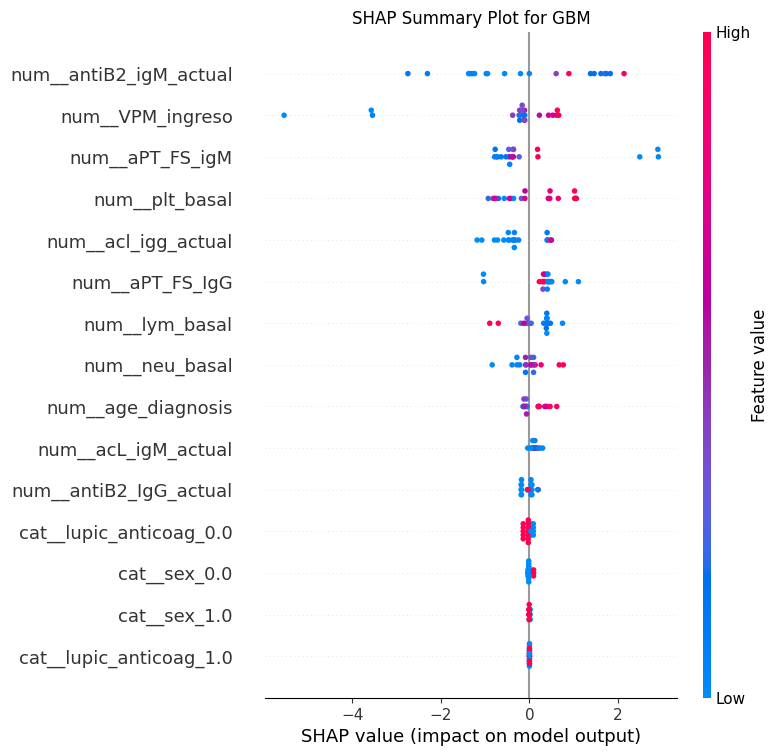

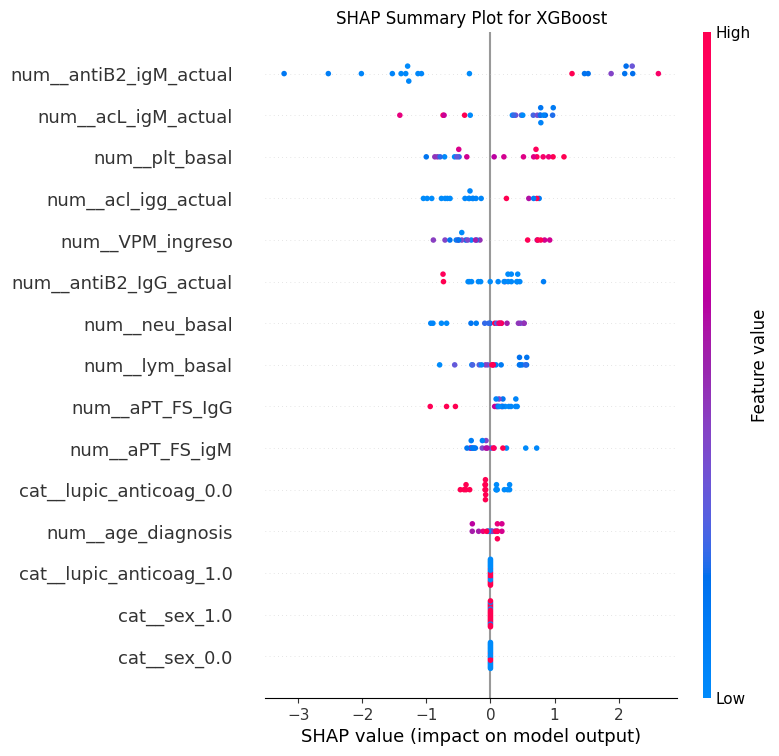

In [21]:
# Plot SHAP summary plots for Gradient Boosting and XGBoost
shap.summary_plot(shap_values_gb, features=models["Gradient Boosting"].named_steps["preprocessor"].transform(X_test), feature_names=preprocessor.get_feature_names_out(), show=False)
plt.title('SHAP Summary Plot for GBM')
plt.show()

shap.summary_plot(shap_values_xgb, features=models["XGBoost"].named_steps["preprocessor"].transform(X_test), feature_names=preprocessor.get_feature_names_out(), show=False)
plt.title('SHAP Summary Plot for XGBoost')
plt.show()